In [1]:
import torch
import torch_geometric
import deepdish as dd
from tqdm import tqdm
import copy
from os.path import join
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures, AllChem
from rdkit import RDConfig
from rdkit.Chem.rdmolfiles import MolFromMolFile
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import random
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Dropout
import torch_geometric.transforms as T
from torch_geometric.nn import  GCNConv, global_add_pool, global_mean_pool,GATConv,GINConv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.data import DataLoader
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset 
from Models.graphLambda import Net

In [2]:
def add_edges_list(root, code):
    '''
    This function creates the graph that represents a molecule. 
    Input: root: root directory of hydrogen-free sdf files of ligands 'str'.
           code: PDB code of the complex containing the ligand 'str'. 
    Output: edges list 'numpy array'
            
    '''
    ligand_filename = code + "_h.sdf"
    m = MolFromMolFile(join(root, code, ligand_filename))
    atoms1 = [b.GetBeginAtomIdx() for b in m.GetBonds()]
    atoms2 = [b.GetEndAtomIdx() for b in m.GetBonds()]    
    # Edge attributes: distance; SINGLE; DOUBLE; TRIPLE; AROMATIC.
    edge_weights= []
    coords = m.GetConformers()[0].GetPositions()  # Get a const reference to the vector of atom positions
    for b in m.GetBonds():
        if str(b.GetBondType()) == "SINGLE":
            edge_weights.append(1)
        elif str(b.GetBondType()) == "DOUBLE":
            edge_weights.append(2)
        elif str(b.GetBondType()) == "TRIPLE":
            edge_weights.append(3)
        else:
            edge_weights.append(4)
    edge_features = np.array(edge_weights) 
    # since the torch-geometric graphs are directed add reverse direction of edges
    return np.array([atoms1 + atoms2, atoms2 + atoms1]), np.concatenate((edge_features, edge_features), 0)

In [3]:
class PDBbindDataset(InMemoryDataset):
    '''
    PDBbindDataset Class: A dataset class that takes root directory, BPS features, and binding affinity values of 
    samples as input. For each complex, the class stores a graph where node features are precomputed BPS
    features, edge features are bond types and target value is the equivalent binding affinity of the given complex.
    Output: A list of graphs.
    '''
    def __init__(self, root, node_features,activity_csv,transform=None, pre_transform=None):
        self.root = root
        self.node_features = node_features
        self.activity_csv = activity_csv
        super(PDBbindDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        pass

    def process(self):

        self.node_data = dd.io.load(join(self.root, self.node_features))
        # load csv with activity data and simlarity scores
        self.activity = pd.read_csv(join(self.root, self.activity_csv))
        # create lists of edges and edge descriptors 
        self.edge_indexes = {key: add_edges_list(self.root, key)[0] for key in self.activity.PDB }
        self.edge_data = {key: add_edges_list(self.root, key)[1] for key in self.activity.PDB }
        
        # Read data into huge `Data` list.
        data_list = [Data(x = torch.FloatTensor(self.node_data[key]),
                          edge_index = torch.LongTensor(self.edge_indexes[key]),
                          edge_attr = torch.FloatTensor(self.edge_data[key]),
                          y = torch.FloatTensor([self.activity[self.activity.PDB == key].pk.iloc[0]])) for key in self.activity.PDB ]
      
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [4]:
path_to_test_directory = "coreset2016"  # the directory that contains folders of PDB complexes to score their affinity
path_to_test_complexes_features =  "coreset.h5"
path_to_test_complexes_true_affinity = "coreset2016.csv"
coreset = PDBbindDataset(path_to_test_directory
                        , path_to_test_complexes_features
                        , path_to_test_complexes_true_affinity)
test_loader = DataLoader(coreset, batch_size=1, shuffle=False)

/Users/ghaith/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
@torch.no_grad()
def test_predictions(model, loader):
    model.eval()
    pred = []
    true = []
    for data in loader:
        data = data.to(device)
        pred += model(data).detach().cpu().numpy().tolist()
        true += data.y.detach().cpu().numpy().tolist()
    return pred, true

### Loading the models

In [8]:
model1= Net() 
model2= Net() 
model3= Net() 
model4= Net() 
model1.load_state_dict(torch.load('GNNs_fusion_rand_split.pt'))
model2.load_state_dict(torch.load('GNNs_fusion_TM_split.pt'))
model3.load_state_dict(torch.load('GNNs_fusion_lig2lig_split.pt'))
model4.load_state_dict(torch.load('GNNs_fusion_interaction_split.pt'))

<All keys matched successfully>

### Predicting binding affinity of test samples

In [9]:
test_loader = DataLoader(coreset, batch_size=64, shuffle=False)
pred, true = test_predictions(model1, test_loader)
pred2, true2 = test_predictions(model2, test_loader)
pred3, true3 = test_predictions(model3, test_loader)
pred4, true4 = test_predictions(model4, test_loader)

### Plotting CASF 16 results

<IPython.core.display.Javascript object>


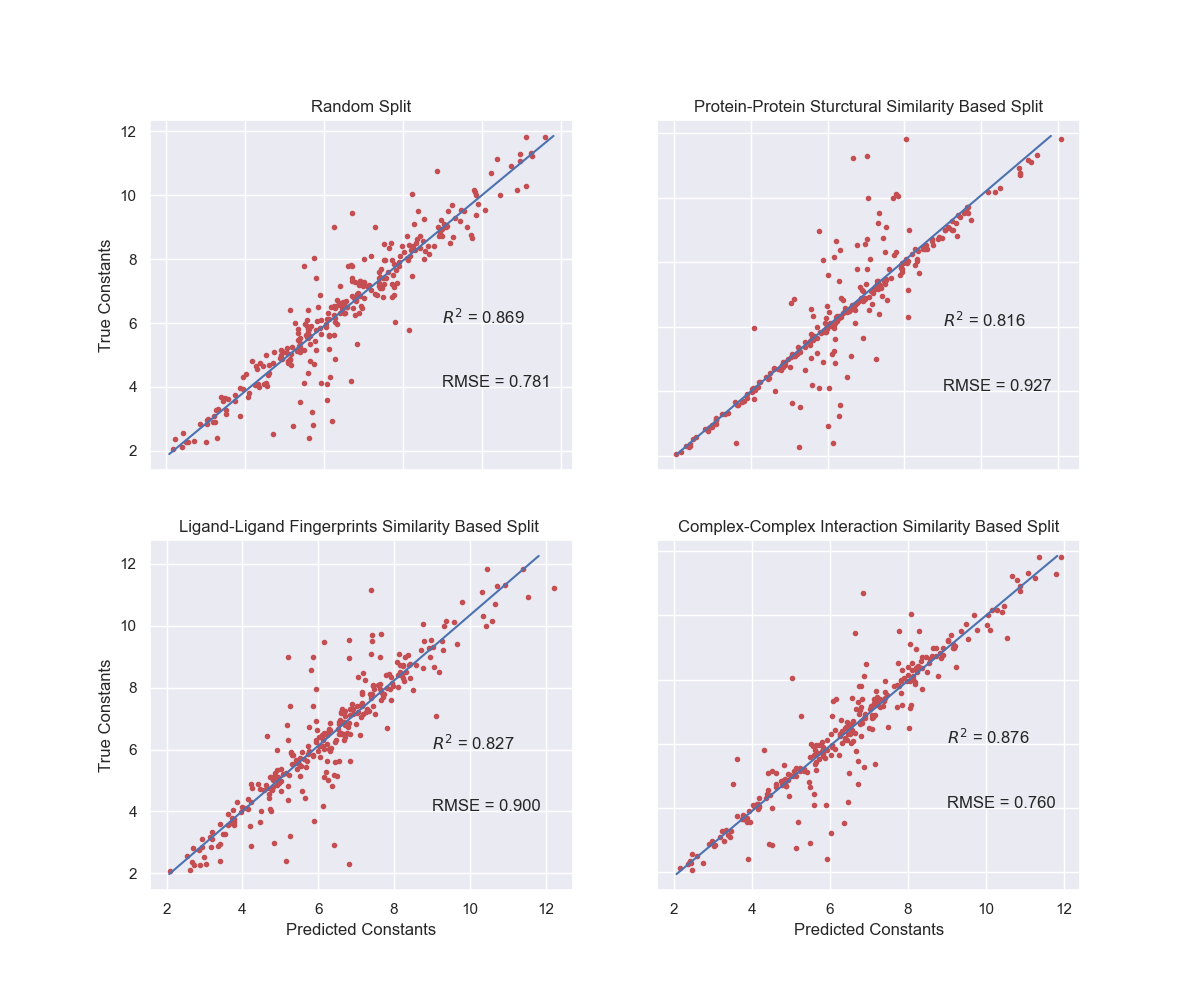

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import math
from matplotlib.pyplot import figure
sns.set()
%matplotlib notebook
fig, axs = plt.subplots(2, 2,figsize=(12,10))
axs[0, 0].plot(pred, true,"r.")
axs[0, 0].plot(np.unique(true), np.poly1d(np.polyfit(pred, true, 1))(np.unique(true)))
axs[0, 0].text(9., 4., "RMSE = "+ str(math.sqrt(mean_squared_error(true, pred)))[:5] )
axs[0, 0].text(9., 6., "$R^{2}$ = "+ str(r2_score(true, pred))[:5])
axs[0, 0].set_title('Random Split')
axs[0, 1].plot(pred2, true2, "r.")
axs[0, 1].plot(np.unique(true2), np.poly1d(np.polyfit(pred2, true2, 1))(np.unique(true2)))
axs[0, 1].text(9., 4., "RMSE = "+ str(math.sqrt(mean_squared_error(true2, pred2)))[:5] )
axs[0, 1].text(9., 6., "$R^{2}$ = "+str(r2_score(true2, pred2))[:5] )
axs[0, 1].set_title('Protein-Protein Sturctural Similarity Based Split')
axs[1, 0].plot(pred3, true3, "r.")
axs[1, 0].plot(np.unique(true3), np.poly1d(np.polyfit(pred3, true3, 1))(np.unique(true3)))
axs[1, 0].text(9., 4., "RMSE = "+ str(math.sqrt(mean_squared_error(true3, pred3)))[:5])
axs[1, 0].text(9., 6., "$R^{2}$ = " +str(r2_score(true3, pred3))[:5] )
axs[1, 0].set_title('Ligand-Ligand Fingerprints Similarity Based Split ')
axs[1, 1].plot(pred4, true4, "r.")
axs[1, 1].plot(np.unique(true4), np.poly1d(np.polyfit(pred4, true4, 1))(np.unique(true4)))
axs[1, 1].text(9., 4., "RMSE = "+  str(math.sqrt(mean_squared_error(true4, pred4)))[:5])
axs[1, 1].text(9., 6., "$R^{2}$ = "+ str(r2_score(true4, pred4))[:5])
axs[1, 1].set_title('Complex-Complex Interaction Similarity Based Split')

for ax in axs.flat:
    ax.set(xlabel='Predicted Constants', ylabel='True Constants')

for ax in axs.flat:
    ax.label_outer()
